<img style="border-radius: 0.5rem;" src="banner.jpg" />
<a style="margin-top: 1rem;" class="btn btn-lg btn-block btn-success" href="https://dsg.ucfsigai.org/fa18/signin/">
    Sign in (https://dsg.ucfsigai.org/fa18/signin/)
</a>

# Intro to Neural Nets, featuring PyTorch
---
by: John Muchovej \([@jmuchovej](github.com/jmuchovej/)\), Chas Kane \([@ChasKane](github.com/ChasKane/)\), on 26 Sep 2018

In [1]:
def dataset(path):
    import os
    from pathlib import Path
    datadir = Path(os.environ["DATA_DIR"])
    return Path(datadir.joinpath(path))

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import helper

device = "cuda:0" if torch.cuda.is_available() else "cpu:0"
torch.device(device)

device(type='cuda', index=0)

In [3]:
def test_net(model, testloader):
    # remember to set the network to evaluation mode
    #   this prevents Dropout (and other things) from 
    #   being activated, thus preventing performance 
    #   dips
    model.eval()

    dataiter = iter(testloader)
    images, labels = dataiter.next()
    img = images[0]
    # Convert 2D image to 1D vector
    img = img.view(1, 784)

    # pass the inpuut through, get back the log-softmax
    with torch.no_grad():
        output = model.forward(img)

    # convert log-softmax to intelligible classes
    ps = torch.exp(output)

    # plot the image and probabilities
    helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')

## Since datasets aren't the focus, we'll be using two "sanity check" datasets – MNIST and Fashion-MNIST

**MNIST** is a dataset of handwritten digits from 0-9. If you look up just abot any Neural Network tutorial, you're practically guaranteed to find this dataset being used, it's one of the earliest problems we tried to solve in what would become machine learning. Now, it's very much a "solved problem" and the US Postal Service uses similar models to actually figure out where youur package is heading based on zip code.

**Fashion-MNIST** is a potential (hopeful) replacement for MNIST, developed by [Zalando Research](https://research.zalando.com/), you can find it (and arguments for it, [here][fmnist]). Generally, the idea is that MNIST is a really easy problem (you'll see this, shortly) and that it doesn't represent the complexity of most tasks we'd actually deal with in modern settings.

For both **MNIST** and **Fashion-MNIST**, they're 28x28 images, totalling to 784 pixels, which can be assigned among 10 classes.

To start out, though, we'll focus on **MNIST**, just putting together a relatively basic neural network.

[fmnist]: https://github.com/zalandoresearch/fashion-mnist

---
### Let's start super advanced, then break it back down :p

I'm going to get a bit advanced here, to expose you to new concepts which you can also spend some time learning about outside of SIGAI. Some of this "advanced-ness" comes from wanting to have an Neural Network which has arbitrarily many layers. That's to say, I want to be able to say `hidden_layers = [512, 256, 128]` and then the hidden layers with sizes of 512, 256, and 128 are constructed for me. I'll be doing this via `nn.ModuleList` – it works prretty much the same as a normal Python list, except that it registers each hidden `Linear` module properly so the model is truly aware of the layers.

However, we need a way to define each `nn.Linear` with appropriate layer sizes... meaning, we need something like this:
```python
# create ModuleList and add an input layer
hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
# add hidden layers to the ModuleList
hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
```

These pairs of input/output sizes can be done via Python's `zip` function:
```python
hidden_layers = [512, 256, 128, 64]
layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
for each in layer_sizes:
    print(each)
    
>> (512, 256)
>> (256, 128)
>> (128, 64)
```

There's also a `forward` method, which retrns the log-softmax for the output. Since softmax is a probability distribtion over classes, the log-softmax is a log probability which comes with [a lot of benefits](https://en.wikipedia.org/wiki/Log_probability). Log probabilities also tend to compute faster and more accurately, so that's definitely dope as well. Later, though, we'll need the class probabilities – which we can get from the exponential of the output (by way of `torch.exp`). Just a refresher on algebra: the exponential fucntion is the inverse of the log function:

$$ \large{e^{\ln{x}} = x } $$

I've opted to include dropouut in out network with [`nn.Dropout`][dropout-docs] as well. This works similarly to other modules, like `nn.Linear`. A required parameters is the dropout probability, which will just pass as input to `Network`.

[fmnist]: https://github.com/zalandoresearch/fashion-mnist
[dropout-docs]: http://pytorch.org/docs/master/nn.html#dropout

In [5]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Download and load the training data
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=True)

To actuaully implement the FMNIST network.

In [6]:
from torch import nn, optim
import torch.nn.functional as F

class FashionMNIST(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p=0.5):
        """ Builds a feedforward network with arbitrarily many hidden layers.
        
            Arguments
            ---------
            input_size: integer, size of the input
            output_size: integer, size of the output layer
            hidden_layers: list of integers, the sizes of the hidden layers
            drop_p: float between 0 and 1, dropout probability
        """
        super().__init__()
        
        # Add the first layer, input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_size)
        
        self.dropout = nn.Dropout(p=drop_p)
        
    def forward(self, x):
        ''' Forward pass through the network, returns the output logits '''
        
        # Forward through each layer in `hidden_layers`, with ReLU activation and dropout
        for linear in self.hidden_layers:
            x = F.relu(linear(x))
            x = self.dropout(x)
        
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)

## Before we train the network, let's take a look at information flow

In [7]:
from IPython.display import IFrame
import math
NN_SVG_W = 732
NN_SVG_H = math.ceil(NN_SVG_W * 0.7076502732) + 20
IFrame("assets/fwd.html", width=NN_SVG_W, height=NN_SVG_H)

For those who couldn't hear me, let's step through this (you should be able to click through this as well):
- you'll see that information flows from the input layer $\mathbf{x}$ to the first hidden layer $\mathbf{h_1}$, then to the second hidden layer $\mathbf{h_2}$, and finally to the output layer $\mathbf{o}$.
- this information flow happens by way of the grey lines connecting $\mathbf{x} \rightarrow \mathbf{h_1}$, $\mathbf{h_1} \rightarrow \mathbf{h_2}$, $\mathbf{h_2} \rightarrow \mathbf{o}$, and so on (if we had more layers).
- these paths between nodes are called **weights**, they're normally represented as matrices, so you'll likely see them written as $W$ in math notation.


**We'll skip the math for now, but hop down to the [Appendix](#Appendix) and you can see it there.**

## Training the network

Since the model's forward method returns the log-softmax, I used the [negative log loss](http://pytorch.org/docs/master/nn.html#nllloss) as my loss function (or criterion), `nn.NLLLoss()`. We'll also use an "industry standard" – [Adam optimizer](http://pytorch.org/docs/master/optim.html#torch.optim.Adam). `Adam` is a variant of stochastic gradient descent which includes momentum and generally trains faster than vanilla SGD.

I've also included a block to measure the validation loss and accuracy. Since I'm using dropout in the network, I need to turn it off during inference. Otherwise, the network will appear to perform poorly because many of the connections are turned off. PyTorch allows you to set a model in "training" or "evaluation" modes with `model.train()` and `model.eval()`, respectively. In training mode, dropout is turned on, while in evaluation mode, dropout is turned off. This effects other modules as well that should be on during training but off during inference.

The validation code consists of a forward pass through the validation set (also split into batches). With the log-softmax output, I calculate the loss on the validation set, as well as the prediction accuracy.

In [8]:
# Create the network, define the criterion and optimizer
model = FashionMNIST(784, 10, [512, 256], drop_p=0.5)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Before we train, let's take a look at how bad this network is.

In [9]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)

/home/john/.conda/envs/sigai-fa18/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


FashionMNIST(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
  )
  (output): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.5)
)

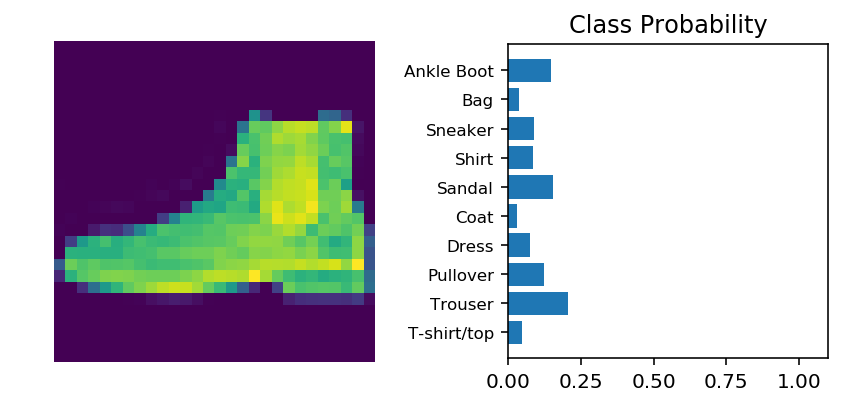

In [11]:
test_net(model, testloader)

In [12]:
# Implement a function for the validation pass
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:

        images.resize_(images.shape[0], 784)

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [13]:
epochs = 2
steps = 0
running_loss = 0
print_every = 40
for e in range(epochs):
    model.train()
    for images, labels in trainloader:
        steps += 1
        
        # Flatten images into a 784 long vector
        images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            # Make sure network is in eval mode for inference
            model.eval()
            
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():
                test_loss, accuracy = validation(model, testloader, criterion)
                
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                  "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
                  "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
            
            running_loss = 0
            
            # Make sure training is back on
            model.train()

Epoch: 1/2..  Training Loss: 1.231..  Test Loss: 0.676..  Test Accuracy: 0.760
Epoch: 1/2..  Training Loss: 0.806..  Test Loss: 0.602..  Test Accuracy: 0.779
Epoch: 1/2..  Training Loss: 0.695..  Test Loss: 0.554..  Test Accuracy: 0.799
Epoch: 1/2..  Training Loss: 0.647..  Test Loss: 0.527..  Test Accuracy: 0.809
Epoch: 1/2..  Training Loss: 0.647..  Test Loss: 0.539..  Test Accuracy: 0.798
Epoch: 1/2..  Training Loss: 0.610..  Test Loss: 0.513..  Test Accuracy: 0.809
Epoch: 1/2..  Training Loss: 0.618..  Test Loss: 0.499..  Test Accuracy: 0.819
Epoch: 1/2..  Training Loss: 0.615..  Test Loss: 0.497..  Test Accuracy: 0.817
Epoch: 1/2..  Training Loss: 0.586..  Test Loss: 0.488..  Test Accuracy: 0.819
Epoch: 1/2..  Training Loss: 0.540..  Test Loss: 0.465..  Test Accuracy: 0.835
Epoch: 1/2..  Training Loss: 0.512..  Test Loss: 0.461..  Test Accuracy: 0.830
Epoch: 2/2..  Training Loss: 0.549..  Test Loss: 0.458..  Test Accuracy: 0.833
Epoch: 2/2..  Training Loss: 0.512..  Test Loss: 0.4

In [14]:
IFrame("assets/bkp.html", width=NN_SVG_W, height=NN_SVG_H)

## Let's see how it does on a random image from testing!

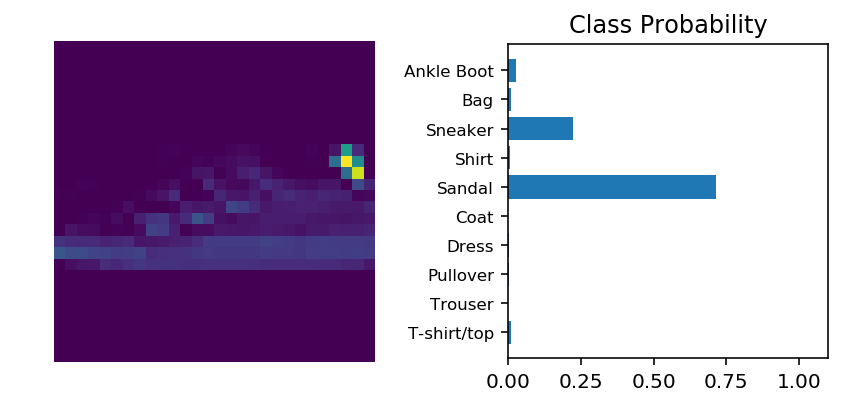

In [21]:
test_net(model, testloader)

# Appendix (will be edited tonight and posted)

## Forward propagation math

## Activation functions

<img src="https://rasbt.github.io/mlxtend/user_guide/general_concepts/activation-functions_files/activation-functions.png">